# **Team Assignment 2 - Predicting ROI**

## 1. Project Overview

https://github.com/aryonna-rice/488-team-assignment-2/tree/main

#### **Introduction:**
In this project, we were tasked with developing a data-driven investment strategy for Dr. D., who is looking to invest $10,000,000 in peer-to-peer lending on LendingClub.com. Utilizing millions of records of accepted loans from LendingClub.com, spanning from 2007 to 2018, our goal was to propose an investment strategy that categorizes potential returns on investment (ROI) as High, Medium, or Low. This strategy is based on a thorough analysis of various factors including loan default probabilities, value and return of loans, loan duration, and payment delinquencies.

#### **Significance of ROI Prediction:**
Predicting ROI is crucial for navigating the complexities of P2P lending. It involves assessing risks, understanding market trends, and making strategic decisions. For Dr. D, accurate ROI forecasts are key to enhancing his portfolio's performance and mitigating potential losses.

#### **Approach Overview:**
Our methodical, data-centric approach includes:

1. **Data Preparation:** Initial exploration and cleaning of LendingClub data to ensure reliability.
2. **Feature Analysis:** Identifying key factors like credit scores and interest rates that influence loan performance and ROI.
3. **Modeling:** Employing machine learning (e.g., Random Forest) to predict loan defaults and estimate returns.
4. **Strategy Development:** Crafting a precise investment strategy based on model insights and testing its effectiveness with historical data.
5. **Recommendations:** Offering Dr. D actionable investment advice and a framework for ongoing strategy adjustment.

## 2. Data Overview
#### **Data Source:**
Our analysis uses data from LendingClub.com, a premier peer-to-peer lending platform. This dataset provides detailed insights into loan applications, borrower profiles, and financial outcomes, making it an ideal foundation for our investment strategy analysis.

#### **Key Variables:**
We focus on essential features that influence loan investment viability and returns, including loan amount, interest rate, loan term, borrower's credit score, employment history, and debt-to-income ratio. These variables are critical for evaluating loan risk and potential returns.

## 3. Computational Environment

For our peer-to-peer lending investment strategy, we required a robust computational setup due to the necessity to process large datasets and train complex models. UNC's Longleaf services were chosen for their capability to efficiently tackle these demands.

#### Why Local Machines Were Not Suitable:

- **Limited Processing Power:** Unable to handle large datasets or complex algorithms efficiently.

- **Insufficient Memory and Storage:** Restricts extensive data manipulation and sophisticated model training.

- **Inadequate for Intensive Tasks:** Falls short in meeting the computational needs for advanced analytics.

#### Benefits of Using Longleaf Services:

- **Scalability:** Manages vast datasets effectively.

- **High Processing Power:** Speeds up computations.

- **Parallel Computing:** Enhances model optimization efficiency.

- **Ample Storage:** Accommodates large data volumes, reducing processing times and facilitating in-depth analysis.

- **Advanced Analytics Capability:** Supports the deployment of complex machine learning models to inform our investment strategy.

## 4. Data Import and Initial Setup
#### Setting Up the Environment

We start by creating a virtual environment to keep dependencies organized and avoid conflicts:

1. **Create**: Run `python -m venv 488env` in the project directory.
2. **Activate**: Use `.\488env\Scripts\activate` on Windows or `source 488env/bin/activate` on Unix/Mac systems.
3. **Install Dependencies**: Execute `pip install -r requirements.txt` to install required libraries.

**Why a Virtual Environment?**: Isolates project libraries from the global Python environment, ensuring consistency across different setups.

#### Project Structure

- `data/`: Contains datasets.
- `imputers/`: Helper functions for data imputation.
- `notebooks/`: Main analysis notebooks.
- `slurm-scripts/`: Batch job scripts.
- `training-scripts/`: Scripts for model training.
- `utils/`: Functions for data preprocessing and feature engineering.
- `requirements.txt`: Project dependencies.

#### Importing Libraries and Data

In the notebook, we import necessary libraries and load the dataset:

```python
# Essential library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
...

# Loading the dataset
df = pd.read_csv('data/cleaned_lending_data.csv')
```

#### Preprocessing Overview (External)

Data preprocessing steps performed outside the notebook include data cleaning, feature selection, outlier removal, and data transformation. This process ensured the dataset's readiness for analysis:

- **Data Cleaning**: Removed missing/incorrect values.
- **Feature Selection**: Dropped non-relevant features based on domain knowledge.
- **Outlier Removal**: Identified and excluded outliers using the IQR method.
- **Data Transformation**: Normalized continuous variables; applied one-hot encoding to categorical ones.

### 4.1 Setting the Correct Path

In [2]:
import sys
from pathlib import Path
# This should be the path to the directory containing 'notebooks' and 'utils'
project_root = Path.cwd().parent  # If your notebook is directly inside the 'notebooks' directory
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

In [3]:
# Check that you are in the right directory
%pwd

'/Users/yejin/Documents/GitHub/488-team-assignment-2/notebooks'

In [4]:
# Automatically loads changes in other files in this project
%load_ext autoreload
%autoreload 2

### 4.2 Importing Needed Libraries

In [5]:
import utils.utility as utility
import imputers.earliest_cr_line_d as ecld
import imputers.numeric_data as nd
# We first import a number of libraries that we will be using in today's class
import pandas as pd
import numpy as np

# Plotting packages we'll use
import matplotlib.pyplot as plt
import seaborn as sns

# Rather than importing the whole sklearn library, we will import only certain modules
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from joblib import load


### 4.3 Importing Accepted Loan Data

In [7]:
path_to_accepted = '../data/LendingClub/accepted_2007_to_2018Q4.csv'

### 4.4 Read Accpeted Data into a Dataframe

In [8]:
df_accepted = pd.read_csv(path_to_accepted)

/var/folders/kh/j4h3xmps6vndhbt9k587bd8w0000gn/T/ipykernel_84304/1670317461.py:1: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accepted = pd.read_csv(path_to_accepted)


In [9]:
# Check rows and columns
print(df_accepted.shape)
df_accepted.head()

(2260701, 151)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## 5. Primary Data Inspection and Feature Selection

### 5.1 Define a List of Features Available for us at Loan's Origin

In [10]:
classifier_features = ["acc_now_delinq", "acc_open_past_24mths", "addr_state","all_util",
    "annual_inc","annual_inc_joint","application_type","avg_cur_bal","bc_open_to_buy",
    "bc_util","chargeoff_within_12_mths","collections_12_mths_ex_med","delinq_2yrs",
    "dti","dti_joint","earliest_cr_line","emp_length","fico_range_high","fico_range_low",
    "funded_amnt","funded_amnt_inv","grade","home_ownership","il_util","initial_list_status",
    "inq_fi","inq_last_12m","inq_last_6mths","installment","int_rate","issue_d",
    "loan_amnt","max_bal_bc","mort_acc","mths_since_last_delinq","mths_since_last_major_derog",
    "mths_since_last_record","mths_since_rcnt_il","mths_since_recent_bc","mths_since_recent_inq",
    "num_accts_ever_120_pd","num_actv_bc_tl","num_actv_rev_tl","num_bc_sats","num_bc_tl","num_il_tl",
    "num_op_rev_tl","num_rev_accts","num_rev_tl_bal_gt_0","num_sats","num_tl_120dpd_2m","num_tl_30dpd",
    "num_tl_90g_dpd_24m","num_tl_op_past_12m","open_acc","open_acc_6m",
    "open_il_12m", "open_il_24m","open_act_il","open_rv_12m","open_rv_24m","pct_tl_nvr_dlq",
    "percent_bc_gt_75","pub_rec","pub_rec_bankruptcies","purpose","revol_bal","revol_util",
    "sub_grade","tax_liens","term","tot_coll_amt","tot_cur_bal","tot_hi_cred_lim","total_acc",
    "total_bal_ex_mort","total_bal_il","total_bc_limit","total_cu_tl","total_il_high_credit_limit",
    "verification_status","verified_status_joint"]


### 5.3 Drop Useless Columns

In [11]:
# Get the column names based on their positions
columns_to_drop = ['id', 'member_id', 'url', 'zip_code']

# Drop irrelevant columns
df_accepted = df_accepted.drop(columns_to_drop, axis=1)

### 5.4 Examine Features (Discuss Implications)

1. **Loan Amount Distribution**: The range of loan amounts (from $500 to $40,000) indicates a diverse set of loans, from small to substantial sums. This variability suggests the importance of analyzing how loan amount impacts default rates and returns.

2. **Interest Rates**: The interest rates vary significantly (from 5.31% to 30.99%), impacting the profitability of loans. Higher rates may correlate with higher risk, necessitating a detailed risk-return analysis.

3. **Borrower Income**: The wide range in annual income (up to $110,000,000) highlights the diversity of borrowers' financial backgrounds. Understanding the relationship between income levels and loan repayment behavior could be critical.

4. **Debt-to-Income Ratio (DTI)**: With DTI ranging from -1 to 999, indicating both negative and exceptionally high values, it's crucial to assess how DTI affects loan performance and to identify a sensible DTI range for investing.

5. **Credit Scores**: The dataset includes a broad spectrum of FICO scores, suggesting the need to evaluate credit score thresholds that optimize investment returns while minimizing risk.

6. **Hardship and Settlement Features**: The presence of hardship and settlement-related features (e.g., hardship_amount, settlement_amount) in a subset of loans indicates that some borrowers face financial difficulties, affecting their ability to repay. Analyzing the impact of these features on overall loan performance could inform risk management strategies.

7. **Outliers and Extreme Values**: The existence of extreme values in features like annual income suggests that outlier detection and handling will be an important preprocessing step to ensure accurate analysis.

8. **Prevalence of Zero Values**: For certain features like delinq_2yrs, the presence of zero values (min value) across a large number of records might necessitate specific handling or interpretation strategies in the context of risk assessment.

In [12]:
df_accepted.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Data columns (total 147 columns):
 #    Column                                      Non-Null Count    Dtype  
---   ------                                      --------------    -----  
 0    loan_amnt                                   2260668 non-null  float64
 1    funded_amnt                                 2260668 non-null  float64
 2    funded_amnt_inv                             2260668 non-null  float64
 3    term                                        2260668 non-null  object 
 4    int_rate                                    2260668 non-null  float64
 5    installment                                 2260668 non-null  float64
 6    grade                                       2260668 non-null  object 
 7    sub_grade                                   2260668 non-null  object 
 8    emp_title                                   2093699 non-null  object 
 9    emp_length                                  

In [13]:
df_accepted.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260668e+06,2.260664e+06,2.258957e+06,2.260639e+06,2.260668e+06,2.260668e+06,...,10917.0,10917.000000,10917.0,10917.000000,8651.000000,10917.000000,10917.000000,34246.000000,34246.000000,34246.000000
mean,1.504693e+04,1.504166e+04,1.502344e+04,1.309283e+01,4.458068e+02,7.799243e+04,1.882420e+01,3.068792e-01,6.985882e+02,7.025884e+02,...,3.0,155.045981,3.0,13.743886,454.798089,11636.883942,193.994321,5010.664267,47.780365,13.191322
std,9.190245e+03,9.188413e+03,9.192332e+03,4.832138e+00,2.671735e+02,1.126962e+05,1.418333e+01,8.672303e-01,3.301038e+01,3.301124e+01,...,0.0,129.040594,0.0,9.671178,375.385500,7625.988281,198.629496,3693.122590,7.311822,8.159980
min,5.000000e+02,5.000000e+02,0.000000e+00,5.310000e+00,4.930000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,6.100000e+02,6.140000e+02,...,3.0,0.640000,3.0,0.000000,1.920000,55.730000,0.010000,44.210000,0.200000,0.000000
25%,8.000000e+03,8.000000e+03,8.000000e+03,9.490000e+00,2.516500e+02,4.600000e+04,1.189000e+01,0.000000e+00,6.750000e+02,6.790000e+02,...,3.0,59.440000,3.0,5.000000,175.230000,5627.000000,44.440000,2208.000000,45.000000,6.000000
50%,1.290000e+04,1.287500e+04,1.280000e+04,1.262000e+01,3.779900e+02,6.500000e+04,1.784000e+01,0.000000e+00,6.900000e+02,6.940000e+02,...,3.0,119.140000,3.0,15.000000,352.770000,10028.390000,133.160000,4146.110000,45.000000,14.000000
75%,2.000000e+04,2.000000e+04,2.000000e+04,1.599000e+01,5.933200e+02,9.300000e+04,2.449000e+01,0.000000e+00,7.150000e+02,7.190000e+02,...,3.0,213.260000,3.0,22.000000,620.175000,16151.890000,284.190000,6850.172500,50.000000,18.000000
max,4.000000e+04,4.000000e+04,4.000000e+04,3.099000e+01,1.719830e+03,1.100000e+08,9.990000e+02,5.800000e+01,8.450000e+02,8.500000e+02,...,3.0,943.940000,3.0,37.000000,2680.890000,40306.410000,1407.860000,33601.000000,521.350000,181.000000


### 5.5 Dropping Columns with a High Null Count


Columns with a high null count were removed from the dataframe in the operation that was shown since statistical analysis and predictive modeling can be seriously compromised by having more than 50% of missing values. The general goal of this stage is to improve the quality of the data so that analyses that come after will be based on more accurate and representative information.

In [14]:
# Drop where the null count is greater than or equal to 50% of samples.
df_accepted, null_columns = utility.drop_null_columns(df_accepted)
classifier_features = [item for item in classifier_features if item not in null_columns]

In [15]:
# View null columns
print(null_columns)

Index(['desc', 'mths_since_last_delinq', 'mths_since_last_record',
       'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint',
       'dti_joint', 'verification_status_joint', 'mths_since_recent_bc_dlq',
       'mths_since_recent_revol_delinq', 'revol_bal_joint',
       'sec_app_fico_range_low', 'sec_app_fico_range_high',
       'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths',
       'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util',
       'sec_app_open_act_il', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med',
       'sec_app_mths_since_last_major_derog', 'hardship_type',
       'hardship_reason', 'hardship_status', 'deferral_term',
       'hardship_amount', 'hardship_start_date', 'hardship_end_date',
       'payment_plan_start_date', 'hardship_length', 'hardship_dpd',
       'hardship_loan_status', 'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardsh

In [16]:
# View df's columns
print(list(df_accepted.columns))

['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev

## 6. Handling Missing Data

### 6.1 Imputing Dates

First, date columns are initially identified and scrutinized for null values. 

To preserve the analytical integrity of the dataset, rows that are missing crucial date information—like the loan's issue date—are removed. 

The date data in the columns are then converted into a consistent datetime format, which makes it easier to conduct temporal analyses that are essential for comprehending loan trends and borrower behavior across time.

In [17]:
df_accepted.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Data columns (total 104 columns):
 #    Column                      Non-Null Count    Dtype  
---   ------                      --------------    -----  
 0    loan_amnt                   2260668 non-null  float64
 1    funded_amnt                 2260668 non-null  float64
 2    funded_amnt_inv             2260668 non-null  float64
 3    term                        2260668 non-null  object 
 4    int_rate                    2260668 non-null  float64
 5    installment                 2260668 non-null  float64
 6    grade                       2260668 non-null  object 
 7    sub_grade                   2260668 non-null  object 
 8    emp_title                   2093699 non-null  object 
 9    emp_length                  2113761 non-null  object 
 10   home_ownership              2260668 non-null  object 
 11   annual_inc                  2260664 non-null  float64
 12   verification_status         2260668 non-

In [18]:
# Get a list of all columns that could be dates (object type)
potential_date_columns = utility.get_object_columns(df_accepted)

In [19]:
# Display each object with its value count
value_counts = utility.display_value_counts(df_accepted, potential_date_columns)
value_counts

{'term': term
 36 months    1609754
 60 months     650914
 Name: count, dtype: int64,
 'grade': grade
 B    663557
 C    650053
 A    433027
 D    324424
 E    135639
 F     41800
 G     12168
 Name: count, dtype: int64,
 'sub_grade': sub_grade
 C1    145903
 B5    140288
 B4    139793
 B3    131514
 C2    131116
 C3    129193
 C4    127115
 B2    126621
 B1    125341
 C5    116726
 A5    107617
 A4     95874
 A1     86790
 D1     81787
 A3     73184
 D2     72899
 A2     69562
 D3     64819
 D4     56896
 D5     48023
 E1     33573
 E2     29924
 E3     26708
 E4     22763
 E5     22671
 F1     13413
 F2      9305
 F3      7791
 F4      6124
 F5      5167
 G1      4106
 G2      2688
 G3      2094
 G4      1712
 G5      1568
 Name: count, dtype: int64,
 'emp_title': emp_title
 Teacher                                38824
 Manager                                34298
 Owner                                  21977
 Registered Nurse                       15867
 Driver                      

In [20]:
# Drop all rows where issue_d is null
df_accepted = df_accepted.dropna(subset=['issue_d'])

In [21]:
# Type cast relevant date columns to date objects
date_columns = ['issue_d', 'earliest_cr_line']
df_accepted = utility.to_datetime(df=df_accepted, columns=date_columns)

#### 6.1.1 Create 'fico_descriptor' Column

- A 'fico_descriptor' column is created to categorize borrowers based on FICO scores into qualitative assessments such as 'Exceptional,' 'Very Good,' 'Good,' 'Fair,' 'Very Poor.'

- This categorical simplification of FICO scores allows for streamlined risk assessment and clearer stratification in the lending analysis.

- Missing dates in the dataset are imputed to maintain the completeness of temporal data, which is essential for accurate loan performance tracking and trend analysis.

In [22]:
df_accepted = utility.get_fico_descriptor(df=df_accepted)
df_accepted['fico_descriptor']

0               Good
1               Good
2               Good
3          Very Good
4               Good
             ...    
2260694         Fair
2260695         Good
2260696         Good
2260697         Fair
2260698         Fair
Name: fico_descriptor, Length: 2260668, dtype: object

In [23]:
# Impute missing dates
ecld_imputer = ecld.EarliestCRLineDateImputer()
ecld_imputer.fit(X=df_accepted)
df_accepted = ecld_imputer.transform(X=df_accepted)

### 6.2 Imputing Categorical Data

- Binned and refined employment length categories, excluding extremes such as "10+ years" and "< 1 year," to improve data uniformity.

- Transformed columns to categorical data types after excluding them as date types for enhanced statistical analysis accuracy.

- Applied mode imputation to categorical fields, replacing missing values with the most frequent category to preserve data distribution.

- There are still some values that are non-null, however, we need to fix this by imputing numerical data as well.

In [24]:
# Binned data
df_accepted = df_accepted[(df_accepted.emp_length != '10+ years') &
                          (df_accepted.emp_length != '< 1 year')]

# Make the rest categorical 
category_columns = utility.get_object_columns(df=df_accepted)
result_list = [item for item in category_columns if item not in date_columns]
df_accepted = utility.to_categorical(df=df_accepted, columns=result_list)

In [25]:
# Impute categorical data using mode
imputer = SimpleImputer(strategy='most_frequent')
df_accepted[category_columns] = imputer.fit_transform(df_accepted[category_columns])

In [26]:
df_accepted.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1322675 entries, 4 to 2260697
Data columns (total 103 columns):
 #    Column                      Non-Null Count    Dtype         
---   ------                      --------------    -----         
 0    loan_amnt                   1322675 non-null  float64       
 1    funded_amnt                 1322675 non-null  float64       
 2    funded_amnt_inv             1322675 non-null  float64       
 3    term                        1322675 non-null  object        
 4    int_rate                    1322675 non-null  float64       
 5    installment                 1322675 non-null  float64       
 6    grade                       1322675 non-null  object        
 7    sub_grade                   1322675 non-null  object        
 8    emp_title                   1322675 non-null  object        
 9    emp_length                  1322675 non-null  object        
 10   home_ownership              1322675 non-null  object        
 11   annual_inc    

### 6.3 Imputing Numerical Data

- Identified numerical columns and applied a grouped median imputation strategy based on the 'fico_descriptor' category, ensuring more tailored and accurate inputation.

- Utilized a custom numeric imputer to handle missing numerical data.

- Replaced missing numeric values with group-specific medians, which could lead to improved model performance.

In [27]:
numerical_columns = utility.get_numerical_columns(df_accepted)
columns_for_grouping_and_median = numerical_columns + ['fico_descriptor']
imputer = nd.NumericDataImputer(group_column='fico_descriptor')
imputer.fit(df_accepted[columns_for_grouping_and_median])
df_accepted[columns_for_grouping_and_median] = imputer.transform(df_accepted[columns_for_grouping_and_median])

/Users/yejin/Documents/GitHub/488-team-assignment-2/imputers/numeric_data.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_transformed[column].fillna(self.medians_[column], inplace=True)


In [28]:
df_accepted.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1322675 entries, 4 to 2260697
Data columns (total 103 columns):
 #    Column                      Non-Null Count    Dtype         
---   ------                      --------------    -----         
 0    loan_amnt                   1322675 non-null  float64       
 1    funded_amnt                 1322675 non-null  float64       
 2    funded_amnt_inv             1322675 non-null  float64       
 3    term                        1322675 non-null  object        
 4    int_rate                    1322675 non-null  float64       
 5    installment                 1322675 non-null  float64       
 6    grade                       1322675 non-null  object        
 7    sub_grade                   1322675 non-null  object        
 8    emp_title                   1322675 non-null  object        
 9    emp_length                  1322675 non-null  object        
 10   home_ownership              1322675 non-null  object        
 11   annual_inc    

## 7. Fixing Skewness

### 7.1 Examine data's distribution

- High skewness in numerical columns is noted so that bias in machine learning models and statistical analysis can be addressed.
- Skewed features are visually inspected to determine whether transformation is required and to direct the skewness correction procedure.
- To equalize distributions and enhance data interpretation and predictive modeling, logarithmic adjustments are done to skewed data.

In [29]:
pd.set_option('display.max_columns', None)  # None means unlimited
df_accepted.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,issue_d,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1322675,1.322675e+06,1.322675e+06,1322675,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1322675.0,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06
mean,1.440358e+04,1.439811e+04,1.437863e+04,1.314650e+01,4.298547e+02,7.384658e+04,2016-04-22 14:14:39.862399744,1.877859e+01,2.865753e-01,2000-10-22 03:42:27.017521408,5.801342e-01,1.140057e+01,1.967430e-01,1.510853e+04,4.954126e+01,2.332622e+01,3.962389e+03,3.961463e+03,1.156481e+04,1.154539e+04,9.111090e+03,2.311710e+03,1.492481e+00,1.405164e+02,2.329691e+01,3.247553e+03,6.859285e+02,6.728298e+02,1.865462e-02,1.0,3.687981e-03,2.282383e+02,1.287048e+05,9.540409e-01,2.543540e+00,4.023074e-01,1.314906e+00,1.810228e+01,3.051635e+04,7.156951e+01,1.183250e+00,2.550001e+00,4.975541e+03,5.764095e+01,3.202419e+04,6.871945e-01,8.148850e-01,1.711610e+00,4.495728e+00,1.233778e+04,1.090187e+04,5.711457e+01,7.864366e-03,1.157493e+01,1.218592e+02,1.697906e+02,1.345326e+01,8.207187e+00,1.317700e+00,2.348371e+01,6.881972e+00,4.802555e-01,3.555598e+00,5.392455e+00,4.638141e+00,7.395535e+00,8.355505e+00,7.948013e+00,1.332762e+01,5.346087e+00,1.140275e+01,5.617404e-04,2.372465e-03,7.886442e-02,2.061821e+00,9.441320e+01,4.129876e+01,1.291557e-01,4.558414e-02,1.612720e+05,4.939739e+04,2.186459e+04,4.284524e+04
min,5.000000e+02,5.000000e+02,0.000000e+00,5.310000e+00,7.610000e+00,0.000000e+00,2007-06-01 00:00:00,-1.000000e+00,0.000000e+00,1934-02-01 00:00:00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.500000e-09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+0

In [30]:
# Get the columns with high skew values as these need to be fixed later
skewed_columns = utility.get_high_skewed_columns(df=df_accepted)

In [31]:
skewed_df = df_accepted[skewed_columns]
skewed_df.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,last_fico_range_high,il_util
count,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06,1.322675e+06
mean,1.440358e+04,1.439811e+04,1.437863e+04,1.314650e+01,6.859285e+02,7.156951e+01
std,8.946151e+03,8.944043e+03,8.947832e+03,4.824584e+00,7.380668e+01,1.740894e+01
min,5.000000e+02,5.000000e+02,0.000000e+00,5.310000e+00,0.000000e+00,0.000000e+00
25%,7.675000e+03,7.675000e+03,7.575000e+03,9.670000e+00,6.540000e+02,6.800000e+01
50%,1.200000e+04,1.200000e+04,1.200000e+04,1.269000e+01,6.990000e+02,7.300000e+01
75%,2.000000e+04,2.000000e+04,2.000000e+04,1.599000e+01,7.340000e+02,7.700000e+01
max,4.000000e+04,4.000000e+04,4.000000e+04,3.099000e+01,8.500000e+02,5.580000e+02


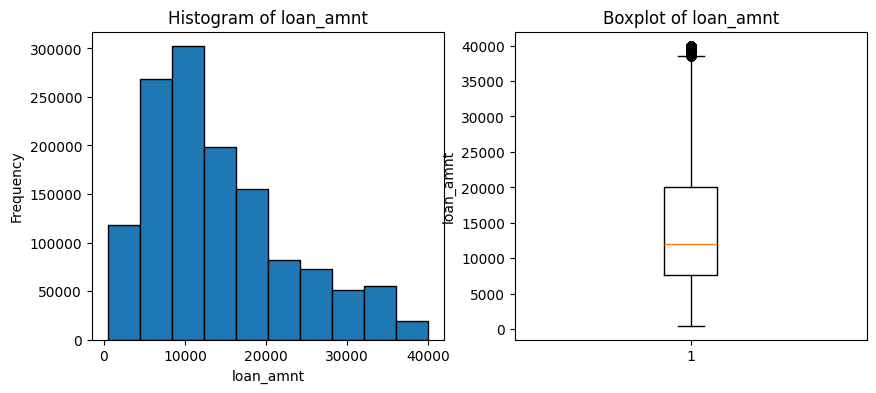

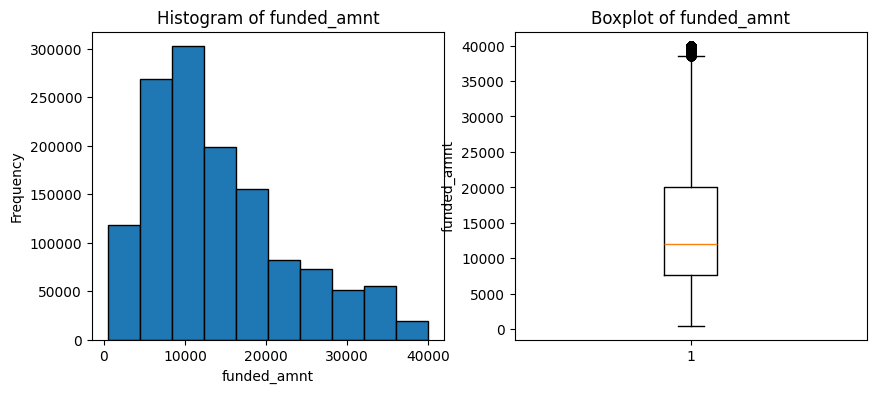

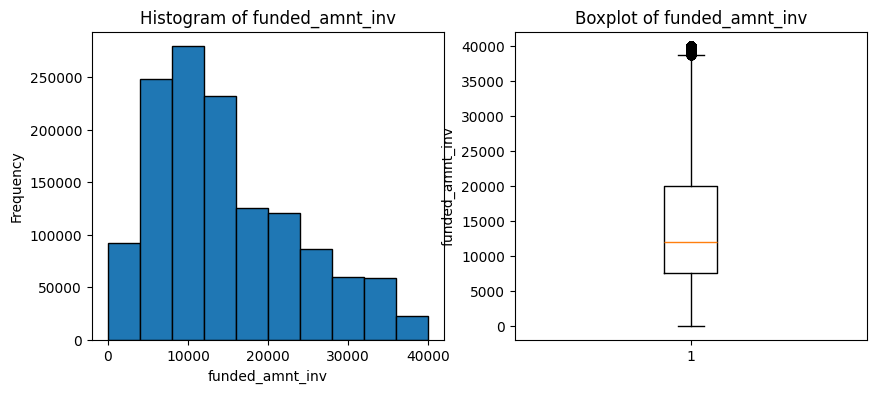

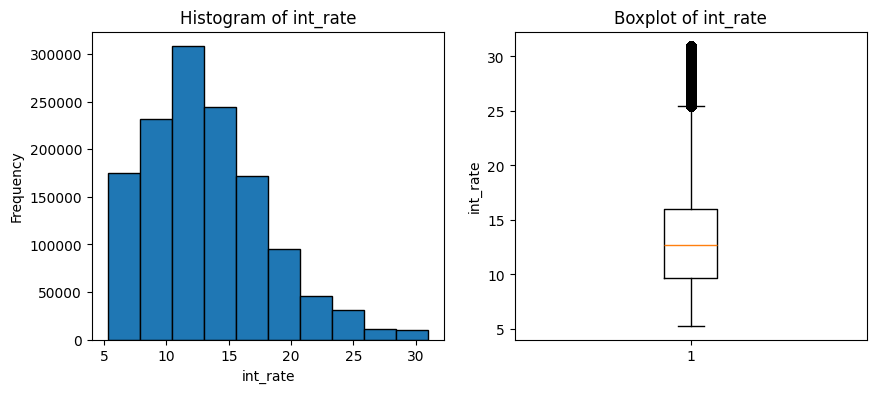

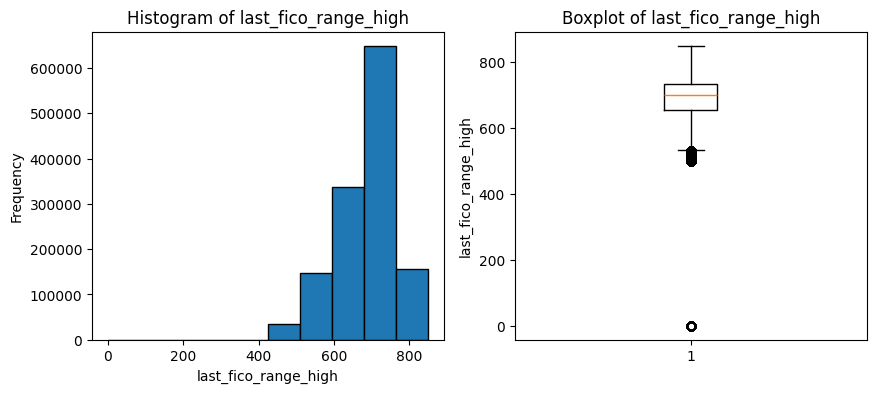

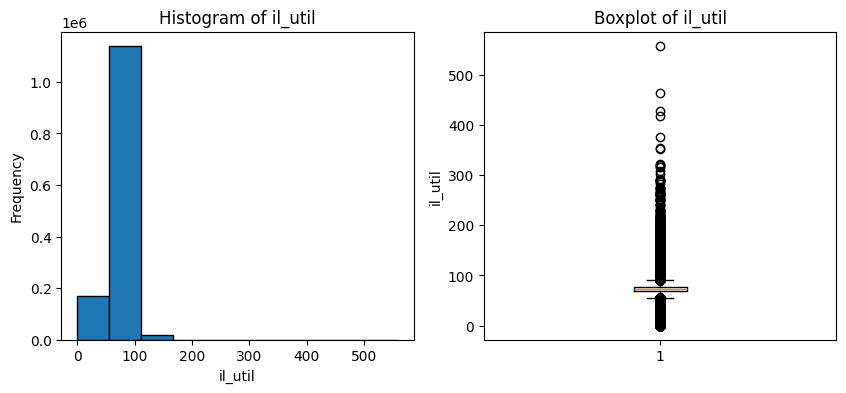

In [32]:
# Visualize skewed features
utility.visualize_numerical_variables(skewed_df)

In [33]:
# Fix skewnes with log
log_df = utility.fix_skewed_features(log_df=df_accepted, skewed_features=skewed_columns)

/Users/yejin/Documents/GitHub/488-team-assignment-2/utils/utility.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  log_df[f + '_log']=np.log1p(log_df[f])
/Users/yejin/Documents/GitHub/488-team-assignment-2/utils/utility.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  log_df[f + '_log']=np.log1p(log_df[f])
/Users/yejin/Documents/GitHub/488-team-assignment-2/utils/utility.py:70: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.

In [34]:
log_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1322675 entries, 4 to 2260697
Data columns (total 103 columns):
 #    Column                      Non-Null Count    Dtype         
---   ------                      --------------    -----         
 0    term                        1322675 non-null  object        
 1    installment                 1322675 non-null  float64       
 2    grade                       1322675 non-null  object        
 3    sub_grade                   1322675 non-null  object        
 4    emp_title                   1322675 non-null  object        
 5    emp_length                  1322675 non-null  object        
 6    home_ownership              1322675 non-null  object        
 7    annual_inc                  1322675 non-null  float64       
 8    verification_status         1322675 non-null  object        
 9    issue_d                     1322675 non-null  datetime64[ns]
 10   loan_status                 1322675 non-null  object        
 11   pymnt_plan    

## 8. Drop outliers

In [35]:
log_df = utility.remove_outliers(df=log_df)

## 9. Standardize Features

- Normalized the data by applying conventional scale to numerical columns, allowing for fair comparison and efficient integration with machine learning techniques.

- StandardScaler was used to ensure that features contribute evenly to the prediction process and avoid bias towards variables with larger magnitudes.

In [36]:
scaler = StandardScaler()
numeric_columns = utility.get_numerical_columns(df=log_df)
log_df = utility.scale_numeric(log_df, numeric_columns, scaler)

In [37]:
log_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 700923 entries, 4 to 2260697
Data columns (total 103 columns):
 #    Column                      Non-Null Count   Dtype         
---   ------                      --------------   -----         
 0    term                        700923 non-null  object        
 1    installment                 700923 non-null  float64       
 2    grade                       700923 non-null  object        
 3    sub_grade                   700923 non-null  object        
 4    emp_title                   700923 non-null  object        
 5    emp_length                  700923 non-null  object        
 6    home_ownership              700923 non-null  object        
 7    annual_inc                  700923 non-null  float64       
 8    verification_status         700923 non-null  object        
 9    issue_d                     700923 non-null  datetime64[ns]
 10   loan_status                 700923 non-null  object        
 11   pymnt_plan                  

In [38]:
# Save a copy
log_df_preFE = log_df.copy(deep=True)

## 10. Feature Engineering

- Engineered new features such as credit history length and payment-to-income ratios to capture more nuanced aspects of borrowers' financial profiles.

- Derived variables like monthly disposable income and investor confidence to provide deeper insights into repayment capacity and loan attractiveness.

- Constructed indicators like average utilization ratio and delinquency score to enrich the dataset with more predictive power for risk assessment models.

In [39]:
# Credit history
log_df['credit_history_length'] = (log_df['issue_d'] - log_df['earliest_cr_line']).dt.days / 365.25

# PTI ratio
log_df['PTI_ratio'] = log_df['installment'] / (log_df['annual_inc']/12)

# Monthly disposable income
log_df['mnthly_disposable_income'] = (log_df['annual_inc'] / 12) - log_df['installment']

# Investor confidence
log_df['investor_confidence'] = log_df['funded_amnt_inv_log'] / log_df['loan_amnt_log']

# Utilization Ratios
log_df['avg_utilization_ratio'] = (log_df['revol_util'] + log_df['bc_util']) / 2

# Historical Delinquencies
log_df['delinquency_score'] = log_df['acc_now_delinq'] + log_df['delinq_2yrs'] + log_df['num_accts_ever_120_pd']

# Credit Inquiry Impact
log_df['credit_inquiry_impact'] = (log_df['inq_last_12m'] * 0.5) + (log_df['inq_last_6mths'] * 0.75) + log_df['inq_fi']

/var/folders/kh/j4h3xmps6vndhbt9k587bd8w0000gn/T/ipykernel_84304/2696554352.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  log_df['credit_history_length'] = (log_df['issue_d'] - log_df['earliest_cr_line']).dt.days / 365.25
/var/folders/kh/j4h3xmps6vndhbt9k587bd8w0000gn/T/ipykernel_84304/2696554352.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  log_df['PTI_ratio'] = log_df['installment'] / (log_df['annual_inc']/12)
/var/folders/kh/j4h3xmps6vndhbt9k587bd8w0000gn/T/ipykernel_84304/2696554352.py:8: PerformanceWarning: Data

In [40]:
log_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 700923 entries, 4 to 2260697
Data columns (total 110 columns):
 #    Column                      Non-Null Count   Dtype         
---   ------                      --------------   -----         
 0    term                        700923 non-null  object        
 1    installment                 700923 non-null  float64       
 2    grade                       700923 non-null  object        
 3    sub_grade                   700923 non-null  object        
 4    emp_title                   700923 non-null  object        
 5    emp_length                  700923 non-null  object        
 6    home_ownership              700923 non-null  object        
 7    annual_inc                  700923 non-null  float64       
 8    verification_status         700923 non-null  object        
 9    issue_d                     700923 non-null  datetime64[ns]
 10   loan_status                 700923 non-null  object        
 11   pymnt_plan                  

### 10.1 Creating Target Variable
- ROI and ROI descriptors are computed and added to the dataset to serve as key target variables, guiding the investment strategy model's focus on loan profitability.

- Non-predictive or post-loan features are removed to prevent data leakage and ensure the model is trained only on information available at the time of loan application.

- The dataset is refined to include only the most relevant features, enhancing model accuracy and reducing complexity for more efficient training and analysis.

In [41]:
# Calculate ROI
log_df = utility.calculate_roi(df=log_df)

/Users/yejin/Documents/GitHub/488-team-assignment-2/utils/utility.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['total_received'] = df['total_pymnt'] + df['recoveries'] - df['collection_recovery_fee']
/Users/yejin/Documents/GitHub/488-team-assignment-2/utils/utility.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ROI'] = ((df['total_received'] - df['funded_amnt_log']) / df['funded_amnt_log'].replace(0, np.nan)) * 100


In [42]:
# Calculate ROI descriptor (High, Medium, Low) based on ROI
log_df = utility.get_roi_descriptor(df=log_df)

/Users/yejin/Documents/GitHub/488-team-assignment-2/utils/utility.py:177: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['ROI_descriptor'] = df['ROI'].apply(categorize_roi)


In [43]:
# Edit classifier features list - can only include data that is available at the time the loan is drafted. Also removed any 
# features that were used to FE other ones to reduce dimensionality 
columns_to_drop = ['fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'il_util', 'int_rate', 'loan_amnt', 'verified_status_joint']
classifier_features = [item for item in classifier_features if item not in columns_to_drop]
classifier_features += ['ROI_descriptor']
classifier_features += ['loan_amnt_log', 'funded_amnt_log', 'funded_amnt_inv_log', 'int_rate_log', 'last_fico_range_high_log', 'il_util_log', 
                        'credit_history_length', 'PTI_ratio', 'mnthly_disposable_income','investor_confidence', 'avg_utilization_ratio',
                        'delinquency_score', 'credit_inquiry_impact']

In [44]:
columns_to_drop = ['installment', 'annual_inc', 'funded_amnt_inv_log', 'loan_amnt_log',
                   'revol_util', 'bc_util', 'acc_now_delinq', 'delinq_2yrs',
                   'num_accts_ever_120_pd', 'inq_last_12m', 'inq_last_6mths', 'inq_fi', 'ROI'] + date_columns


classifier_features = [item for item in classifier_features if item not in columns_to_drop]

log_df = log_df[classifier_features]

In [45]:
log_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 700923 entries, 4 to 2260697
Data columns (total 69 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   acc_open_past_24mths        700923 non-null  float64
 1   addr_state                  700923 non-null  object 
 2   all_util                    700923 non-null  float64
 3   application_type            700923 non-null  object 
 4   avg_cur_bal                 700923 non-null  float64
 5   bc_open_to_buy              700923 non-null  float64
 6   chargeoff_within_12_mths    700923 non-null  float64
 7   collections_12_mths_ex_med  700923 non-null  float64
 8   dti                         700923 non-null  float64
 9   emp_length                  700923 non-null  object 
 10  grade                       700923 non-null  object 
 11  home_ownership              700923 non-null  object 
 12  initial_list_status         700923 non-null  object 
 13  max_bal_bc        

## 11. Encoding Categorical Variables

- Calculated the Return on Investment (ROI) to quantify the profitability of loans, enabling a clear target for model predictions.

- Created an ROI descriptor to categorize the ROI into ordinal levels of High, Medium, and Low, providing a qualitative assessment for analysis.

- Streamlined feature set by excluding data not available at loan issuance and redundant features to enhance model efficiency and reduce overfitting.

In [46]:
category_columns = utility.get_object_columns(df=log_df)
log_df = utility.to_categorical(df=log_df, columns=category_columns)

/Users/yejin/Documents/GitHub/488-team-assignment-2/utils/utility.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype('category')
/Users/yejin/Documents/GitHub/488-team-assignment-2/utils/utility.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[column].astype('category')
/Users/yejin/Documents/GitHub/488-team-assignment-2/utils/utility.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

In [47]:
log_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 700923 entries, 4 to 2260697
Data columns (total 69 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   acc_open_past_24mths        700923 non-null  float64 
 1   addr_state                  700923 non-null  category
 2   all_util                    700923 non-null  float64 
 3   application_type            700923 non-null  category
 4   avg_cur_bal                 700923 non-null  float64 
 5   bc_open_to_buy              700923 non-null  float64 
 6   chargeoff_within_12_mths    700923 non-null  float64 
 7   collections_12_mths_ex_med  700923 non-null  float64 
 8   dti                         700923 non-null  float64 
 9   emp_length                  700923 non-null  category
 10  grade                       700923 non-null  category
 11  home_ownership              700923 non-null  category
 12  initial_list_status         700923 non-null  category
 13  max

In [48]:
# Run once - must remove ROI_descriptor because this is our target 
category_columns = utility.get_category_columns(df=log_df)
category_columns.remove('ROI_descriptor')
print(category_columns)

['addr_state', 'application_type', 'emp_length', 'grade', 'home_ownership', 'initial_list_status', 'purpose', 'sub_grade', 'term', 'verification_status']


In [49]:
# One hot encoding on all (except ROI_descriptor)
log_df = utility.one_hot_encode(df=log_df, columns_to_encode=category_columns)

In [50]:
log_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 700923 entries, 4 to 2260697
Data columns (total 190 columns):
 #    Column                               Non-Null Count   Dtype   
---   ------                               --------------   -----   
 0    acc_open_past_24mths                 700923 non-null  float64 
 1    all_util                             700923 non-null  float64 
 2    avg_cur_bal                          700923 non-null  float64 
 3    bc_open_to_buy                       700923 non-null  float64 
 4    chargeoff_within_12_mths             700923 non-null  float64 
 5    collections_12_mths_ex_med           700923 non-null  float64 
 6    dti                                  700923 non-null  float64 
 7    max_bal_bc                           700923 non-null  float64 
 8    mort_acc                             700923 non-null  float64 
 9    mths_since_rcnt_il                   700923 non-null  float64 
 10   mths_since_recent_bc                 700923 non-null  floa

In [51]:
# Save targets
y = log_df['ROI_descriptor'].values

In [52]:
# Check to see if number of y's = len of log_df
print(len(y))

700923


## 12. Training

In [53]:
X = log_df.drop(columns='ROI_descriptor')

### 12.1 Explain that X and y are Saved for Cross Validation and Good Practice

- Features (X) and target variable (y) are stored to ensure consistent data use in cross-validation, allowing for an accurate assessment of the Random Forest Classifier's performance.

- This strategy improves model evaluation reproducibility and integrity while also adhering to scientific rigor and transparency.

- Securing these datasets eliminates data leaks and provides reliable cross-validation, which is required for legitimate machine learning.

### 12.2 Split

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### 12.3 Explain that X_train and y_train are Saved for Training the Model

- `X_train` and `y_train` are saved for consistent training conditions, ensuring the model can be reliably fine-tuned and validated against unchanged data.
  
- This practice enables the application of cross-validation techniques to assess the model's performance, important for avoiding overfitting and bias.

- The datasets are derived from processed features significant for predicting ROI, allowing future model iterations to be aligned with initial findings and methodology.



In [55]:
# (DO ONCE: ALREADY DONE) SAVE FOR TRAINING THE MODEL
#dump(X_train, '/nas/longleaf/home/aryonna/488-team-assignment-2/data/train_data/features.joblib')

# Save labels
#dump(y_train, '/nas/longleaf/home/aryonna/488-team-assignment-2/data/train_data/target.joblib')

# EXPLANATION: This code saves X_train and y_train to a .joblib file for a model to use later to
# train a model with a script. I'm just leaving this here so you can explain how/ where we got the data from. 
# This should not be ran. Simply here demo purposes.

In [56]:
# After training, these features were deemed the most important based on "mean" meaning their 
# imporatnce was over the average importance. These were generated from the rfc.py training script
most_important_features = ["max_bal_bc", "mths_since_rcnt_il", 
                           "revol_bal", "total_bal_il", "funded_amnt_log", 
                           "int_rate_log", "last_fico_range_high_log", "PTI_ratio", 
                           "mnthly_disposable_income", "investor_confidence"]

### 12.4 Reduce Data Based on Feature Importance

- The dataset is pruned to only include the most impactful features identified through model training to enhance model accuracy and simplify complexity.

- Reducing the feature space minimizes overfitting and improves computational efficiency during cross-validation and testing phases.

- The most important features are saved for future validation to ensure consistency in model performance assessment and enable swift model iteration.

In [57]:
reduced_data = X[most_important_features]

In [58]:
# SAVE RAW REDUCED DATA FOR CROSS VALIDATION
#dump(reduced_data, '/nas/longleaf/home/aryonna/488-team-assignment-2/data/raw_data/features.joblib')

# Save labels
#dump(y, '/nas/longleaf/home/aryonna/488-team-assignment-2/data/raw_data/target.joblib')

# EXPLANATION: This code saves X and y to a .joblib file for cross validation on the important features
# I'm just leaving this here so you can explain how/ where we got the data from. 
# This should not be ran. Simply here demo purposes.

In [59]:
# Loading the model that was generated in the rfc.py script
rfc = load('../models/rfc_reduced_data.joblib')
y_pred = rfc.predict(X_test[most_important_features])

/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [60]:
# Check the accuracy on the test set
accuracy_rf = rfc.score(X_test[most_important_features], y_test)
print(f"Accuracy of Random Forest: {accuracy_rf}")


/opt/homebrew/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Accuracy of Random Forest: 0.5720155508791953


## 13. Cross-Validation

- Cross-validation is used to evaluate the predictive model's resilience and generalizability across several data subsets.

- It entails dividing the data into subsets, training the model on some of them (the training set), and testing it on others (the validation set), to ensure that the model's performance is consistent.

- The technique reduces the risk of overfitting by confirming the model's efficacy on independent data segments while also providing a realistic estimate of its performance on previously unknown data.


In [119]:
# Define the file path from which to read the results
cross_val_results_path = '../cross-val-results/rfc_reduced_results.txt'  # Update this to your actual file path

# Open the file in read mode ('r') and print its contents
with open(cross_val_results_path, 'r') as file:
    results = file.read()

# Print the results
print(results)

Fold 1 Accuracy: 0.8205
Fold 2 Accuracy: 0.8208
Fold 3 Accuracy: 0.8216
Fold 4 Accuracy: 0.8208
Fold 5 Accuracy: 0.8205

Average Accuracy: 0.8208 ± 0.0004


## 14. Possible Optimizations

1) **Model Exploration and Tuning:**

   - Investigate a broader range of machine learning models and methods beyond the existing scope in order to identify potentially better fitting models for the data.

   - Conduct a more extensive hyperparameter tuning process, such as grid search or randomized search, to determine the best settings for each model.

2. **Feature Engineering:**

   - Look into new feature engineering strategies to identify more complicated correlations in the data that could increase model performance.

   - Use dimensionality reduction techniques such as Principal Component Analysis (PCA) to find the most informative characteristics while reducing computing costs.

3. **Ensemble Methods:**

   - Create ensemble models that incorporate predictions from many models to increase accuracy and limit the risk of overfitting.

   - Implement advanced ensemble techniques such as stacking or mixing to exploit the strengths of different individual models.

4. **Computing Efficiency:**

   - Optimize code for performance to reduce runtime, especially when training complex models or modifying hyperparameters.

5. **Validation and Testing:**

   - Use more robust validation procedures, such as nested cross-validation, to measure model generalization error.

   - Increase the number of folds in cross-validation to reduce variability in performance estimations.


## 15. Conclusions and Findings

After analyzing data from LendingClub.com covering loans from 2007 to 2018, we developed a focused investment strategy for Dr. D’s $10,000,000 investment in peer-to-peer lending. Our strategy targets loans classified as 'High' ROI, based on a detailed examination of borrower profiles.

**Strategic Insights:**

- **High ROI Loans**: Our analysis pinpoints loans with high return potential as optimal investment targets, balancing risk and reward by leveraging insights into borrowers' creditworthiness and loan specifics.

- **Risk Awareness**: Incorporating factors such as loan duration and payment history enhances our strategy’s risk resilience, ensuring a well-informed investment approach.

- **Investment Allocation**: We recommend Dr. D to invest primarily in 'High' ROI loans, optimizing for both security and profitability within the peer-to-peer lending landscape.

**Moving Forward**:

To maintain and possibly enhance returns, we suggest ongoing strategy evaluation against market changes and further analytical enhancements. Diversification across loan types and continuous data analysis will be key to adapting and capitalizing on peer-to-peer lending opportunities.

In essence, our concise strategy offers Dr. D a clear path to investing in peer-to-peer lending, emphasizing high-return loans while mindful of underlying risks. This approach illustrates the efficacy of data-driven strategies in navigating financial investment landscapes.